NECESSARY STEP: Import all required packages.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

STEP 1: Acquiring the Dataset from Kaggle: https://www.kaggle.com/code/esparko/getting-started-tweet2map-dataset/input

In [2]:
# Read the file path from Kaggle and return a DataFrame of recorded road accidents in Metro Manila from 2018-2020
data = pd.read_csv("data_mmda_traffic_spatial.csv")

# Display the first few rows of the DataFrame
data.head()

,Date,Time,City,Location,Latitude,Longitude,High_Accuracy,Direction,Type,Lanes_Blocked,Involved,Tweet,Source
0,2018-08-20,7:55 AM,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,1,EB,VEHICULAR ACCIDENT,1.0,TAXI AND MC,MMDA ALERT: Vehicular accident at Ortigas Emer...,https://twitter.com/mmda/status/10313302019705...
1,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313462477459...
2,2018-08-20,9:13 AM,Makati City,EDSA ROCKWELL,14.559818,121.040737,1,SB,VEHICULAR ACCIDENT,1.0,SUV AND L300,MMDA ALERT: Vehicular accident at EDSA Rockwel...,https://twitter.com/mmda/status/10313589669896...
3,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313590696535...
4,2018-08-20,10:27 AM,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,1,EB,VEHICULAR ACCIDENT,1.0,2 CARS,MMDA ALERT: Vehicular accident at Ortigas Club...,https://twitter.com/mmda/status/10313711248424...


Step 2: Preprocessing the Dataset

In [3]:
# Drop rows with NaN, 0.0, irrelevant, and duplicate values
data.dropna(subset=["Date", "Time", "Longitude", "Latitude"], inplace=True)
data = data[(data['Latitude'] != 0.0) & (data['Longitude'] != 0.0) & (data['Time'] != 0.0) & (data['Date'] != 0.0)]
data.drop(["Source", "High_Accuracy", "Tweet", "Direction", "Type", "Lanes_Blocked", "Involved"], axis=1, inplace=True)
data.drop_duplicates(inplace=True)

# Convert Longitude and Latitude to float
data["Longitude"] = data["Longitude"].astype(float)
data["Latitude"] = data["Latitude"].astype(float)

# Extract the Hour, Minute, and AM/PM Information from the Time Column
time_pattern = r'(\d{1,2}):(\d{2})\s*(AM|PM)'
data[["Hour", "Minute", "AM/PM"]] = data["Time"].str.extract(time_pattern, expand=True)

# Fill-in missing values of the Hour and Minute columns with 0
data["Hour"].fillna(0, inplace=True)
data["Minute"].fillna(0, inplace=True)

# Convert the Hour and Minute Columns to integer
data["Hour"] = data["Hour"].astype(int)
data["Minute"] = data["Minute"].astype(int)

# 12-hour format to 24-hour format
data.loc[data["AM/PM"] == "PM", "Hour"] += 12

# Handles invalid hour values by using modulo division
data.loc[data["Hour"] > 23, "Hour"] = data["Hour"] % 24

# Handles invalid minute values by using modulo division
data.loc[data["Minute"] > 59, "Minute"] = data["Minute"] % 60

# New Time column with the format HH:MM
data["Time"] = data["Hour"].map("{:02d}".format) + ":" + data["Minute"].map("{:02d}".format)

# Combines the Date and Time to datetime format and maps to their corresponding ordinal representation
data["Datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data["Datetime"] = data["Datetime"].map(datetime.toordinal)

Step 3: Clustering using the K-means Algorithm

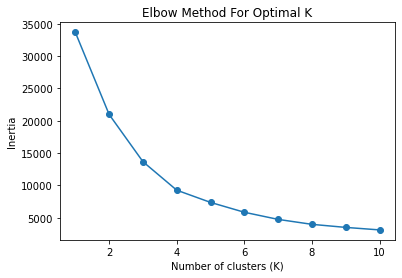

In [4]:
# Subset of columns that will be used for clustering
features = data[["Longitude", "Latitude"]]

# Standardize and scale the features first before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Storage of inertia values for different values of K
inertia = []

# Determine the optimal number of clusters
for K in range(1, 11):
    # Perform K-means for each K and store its inertia value
    kmeans = KMeans(n_clusters=K, random_state=0)
    clusters = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the K vs Inertia to visualize their relationship and use elbow method
plt.plot(range(1, 11), inertia, 'o-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# Perform K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)

# Assign and label each data record to a cluster
data["cluster"] = kmeans.fit_predict(scaled_features)

Step 4: Modeling using the Linear Regression Algorithm

In [5]:
# Identify distinct clusters
clusters = data["cluster"].unique()

# Initialize the dictionary for all regression models later
regression_models = {}

# Iterate through all the clusters
for cluster in clusters:
    # Filter the DataFrame for the current cluster
    cluster_data = data[data["cluster"] == cluster]
    # Input Feature = Datetime
    X = cluster_data[["Datetime"]]
    # Target Variable = Number of Accidents
    # Each row represents 1 accident
    y = range(1, len(cluster_data) + 1)
    # 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # Train the model by fitting to the training data and store in the dictionary
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    regression_models[cluster] = regression_model

Step 5: Evaluating the Regression Models

In [6]:
# Iterates through all regression models
for cluster, regression_model in regression_models.items():
    # Filter the DataFrame for the current cluster
    cluster_data = data[data["cluster"] == cluster]
    # Input Feature = Datetime
    X = cluster_data[["Datetime"]]
    # Target Variable = Number of Accidents
    # Each row represents 1 accident
    y = range(1, len(cluster_data) + 1)
    # Make predictions using the regression model and input features  
    y_pred = regression_model.predict(X)
    # Perform important metrics
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    # Print the results for each cluster
    print(f"Cluster {cluster} Evaluation:")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print("")

    # Calculate the mean of the target variable
    mean_accidents = len(cluster_data) / len(data["cluster"].unique())
    baseline_predictions = np.full_like(X, mean_accidents)
    # Evaluate the performance of the baseline model
    mse_baseline = mean_squared_error(y, baseline_predictions)
    rmse_baseline = np.sqrt(mse_baseline)
    # Print the results for the baseline model
    print("Baseline Model Performance:")
    print("Root Mean Squared Error (RMSE):", rmse_baseline)
    print("------------------------------------")

Cluster 3 Evaluation:
RMSE: 544.7744033691268
R-squared: 0.9465147139880162

Baseline Model Performance:
Root Mean Squared Error (RMSE): 3116.478808955175
------------------------------------
Cluster 1 Evaluation:
RMSE: 279.69138102785104
R-squared: 0.9290335887766403

Baseline Model Performance:
Root Mean Squared Error (RMSE): 1389.393392815728
------------------------------------
Cluster 2 Evaluation:
RMSE: 196.7083891517047
R-squared: 0.9483044009366389

Baseline Model Performance:
Root Mean Squared Error (RMSE): 1144.9893740409414
------------------------------------
Cluster 0 Evaluation:
RMSE: 138.0805757422909
R-squared: 0.9456634807138213

Baseline Model Performance:
Root Mean Squared Error (RMSE): 783.947808636944
------------------------------------


Step 6: Predicting using the Regression Models

In [7]:
# Predict which cluster has the highest number of accidents at August 20, 2018, at 12:55:00
prediction_datetime = datetime(2018, 8, 20, 12, 55, 0)
# Convert datetime to ordinal
prediction_datetime_ordinal = prediction_datetime.toordinal()

# Initialize for tracking of clusters
predicted_cluster = None
max_accident_count = 0

# Iterates through all clusters
for cluster_id in range(4):
    # Predict the accident count using the cluster's regression model with datetime as the input
    regression_model = regression_models[cluster_id]
    predicted_accident_count = regression_model.predict([[prediction_datetime_ordinal]])
    # Updates the maximum accident count and assigns the corresponding cluster
    if predicted_accident_count > max_accident_count:
        max_accident_count = predicted_accident_count
        predicted_cluster = cluster_id

# Show only the rows that belong in the predicted cluster
locations_with_highest_accidents = data[data["cluster"] == predicted_cluster][["Location", "Datetime", "Date", "Time", "Longitude", "Latitude"]]

# Output the results
print("Cluster with Highest Number of Accidents at", prediction_datetime, "is Cluster", predicted_cluster, ":")
print(locations_with_highest_accidents)
print(int(max_accident_count))

Cluster with Highest Number of Accidents at 2018-08-20 12:55:00 is Cluster 3 :
                    Location  Datetime        Date   Time   Longitude  \
0            ORTIGAS EMERALD    736926  2018-08-20  07:55  121.061481   
1                EDSA GUADIX    736926  2018-08-20  08:42  121.057243   
2              EDSA ROCKWELL    736926  2018-08-20  09:13  121.040737   
4      ORTIGAS CLUB FILIPINO    736926  2018-08-20  10:27  121.046754   
5                C5 KALAYAAN    736926  2018-08-20  11:18  121.062936   
...                      ...       ...         ...    ...         ...   
17304       EDSA ORTIGAS MRT    737785  2020-12-26  22:35  121.056314   
17305        EDSA QUEZON AVE    737786  2020-12-27  11:10  121.054467   
17308          EDSA ESTRELLA    737786  2020-12-27  15:08  121.040737   
17309  EDSA P TUAZON FLYOVER    737786  2020-12-27  15:23  121.052548   
17310  ORTIGAS AVE EDSA POEA    737786  2020-12-27  19:46  121.058028   

        Latitude  
0      14.586343  
1     